In [4]:
!pip install pandas
!pip install numpy==2.0.2
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install imbalanced-learn
!pip install xgboost
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)


In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [74]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
from sklearn.preprocessing import LabelEncoder
class DataProcessing(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def process_static_choice_values(self, X):
        ''' Replace variables with static values: yes, no, unknown '''

        X = X.copy()
        columns_to_replace = ['default', 'housing', 'loan']
        map_to_replace = {"yes": 1, "no": 0, "unknown": -1}
        
        for column_name in columns_to_replace:
            X[column_name] = X[column_name].map(map_to_replace)
    
        return X
    
    def process_education_column(self, X):
        ''' Executes ordinal encoder for education column. Replace string values onto integer values. '''

        X = X.copy()
        encoder = OrdinalEncoder(categories = [['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']])
        X['education'] = encoder.fit_transform(X[['education']])
        
        return X
    
    def process_one_hot_encoding(self, X):
        ''' Create One Hot encoding for object type columns '''

        X = X.copy()
        categorical_cols = X.select_dtypes(include=['object']).columns
        
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_array = encoder.fit_transform(X[categorical_cols])
        encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)
        
        X = X.drop(columns=categorical_cols).reset_index(drop=True)
        encoded_df = encoded_df.reset_index(drop=True)
        
        return pd.concat([X, encoded_df], axis=1)

    def process_target(self, y):
        ''' Replace string values onto integer '''
        return np.where(y == "yes", 1, 0)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ''' Apply all transformations to the dataset '''
        X = self.process_static_choice_values(X)
        X = self.process_education_column(X)
        X = self.process_one_hot_encoding(X)
        
        return X

In [10]:
class FeatureEngineering(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def create_new_categories(self, X):
        ''' Create new categories based on EDA 
            # для мінімізації викидів, логарифмую змінну duration
            # створюю нову категорію користувачів з pdays = 999, previous=0
            # створюю нову категорію для користувачів з campaign <= 3
        '''
        
        X = X.copy()
        X['is_pdays_999'] = X['pdays'].apply(lambda x: 1 if x == 999 else 0)
        X['less_3_campaign'] = X['campaign'].apply(lambda x: 1 if x <= 3 else 0)
        X['no_previous'] = X['previous'].apply(lambda x: 1 if x == 0 else 0)
    
        return X
    
    def logarithmise_duration(self, X):
        ''' Logarithmise column '''
        
        X = X.copy()
        X['duration'] = X['duration'].apply(lambda x: np.log1p(x))
    
        return X

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ''' Apply all transformations to the dataset '''
        X = self.create_new_categories(X)
        X = self.logarithmise_duration(X)

        return X

In [11]:
def train_main_pipeline(df, model, param_grid, sampler=None):
    '''
        Function for training models with specific parameters for grid search
    '''
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    if sampler and sampler.lower() == 'adasyn':
        pipeline = Pipeline([
            ('data_processing', DataProcessing()),
            ('feature_engineering', FeatureEngineering()),
            ('min_max_scaler', MinMaxScaler()),
            ('sampler', ADASYN(random_state=42, n_neighbors=8)),
            ('model', model)
        ])
    elif sampler and sampler.lower() == 'smote':
        pipeline = Pipeline([
            ('data_processing', DataProcessing()),
            ('feature_engineering', FeatureEngineering()),
            ('min_max_scaler', MinMaxScaler()),
            ('sampler', SMOTE(random_state=42)),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('data_processing', DataProcessing()),
            ('feature_engineering', FeatureEngineering()),
            ('min_max_scaler', MinMaxScaler()),
            ('model', model)
        ])
    
    cross_validation_data = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=cross_validation_data, scoring='roc_auc', n_jobs=-1, verbose=2, return_train_score=True)
    grid_search.fit(X, y)

    results = {
        "Model": pipeline,
        "Model name": grid_search.best_estimator_['model'],
        "Mean train score": grid_search.cv_results_.get('mean_train_score').mean(),
        "Mean test score": grid_search.cv_results_.get('mean_test_score').mean(),
    }

    return results

In [12]:
def train_xgb_pipeline(df, model, param_grid):
    '''
        Function for training XGB models with specific parameters for random search
    '''
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    pipeline = Pipeline([
        ('data_processing', DataProcessing()),
        ('feature_engineering', FeatureEngineering()),
        ('min_max_scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    cross_validation_data = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, cv=cross_validation_data, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=42, return_train_score=True)
    random_search.fit(X, y)

    results = {
        "Model": pipeline,
        "Model name": random_search.best_estimator_['model'],
        "Mean train score": random_search.cv_results_.get('mean_train_score').mean(),
        "Mean test score": random_search.cv_results_.get('mean_test_score').mean(),
        "Params Tuning": "Randomized Search"
    }

    return results

In [13]:
def train_xgb_hyperport(df, param_grid):
    '''
        Function for training XGB models with hyperport tuning
    '''
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    def objective_xgb(params):
        ''' Objective function for hyperport tuning '''
        
        xgb_clf = XGBClassifier(
            n_estimators = int(params['n_estimators']),
            learning_rate = params['learning_rate'],
            max_depth = int(params['max_depth']),
            min_child_weight = params['min_child_weight'],
            subsample = params['subsample'],
            colsample_bytree = params['colsample_bytree'],
            reg_alpha = params['reg_alpha'],
            reg_lambda = params['reg_lambda'],
            enable_categorical = True,
            missing = np.nan
        )
    
        pipeline = Pipeline([
            ('data_processing', DataProcessing()),
            ('feature_engineering', FeatureEngineering()),
            ('min_max_scaler', MinMaxScaler()),
            ('model', xgb_clf)
        ])
        
        cross_validation_data = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        score = cross_val_score(pipeline, X, y, cv=cross_validation_data, scoring='roc_auc', n_jobs=-1).mean()
        result = {'loss': -score, 'status': STATUS_OK}
        
        return result

    trials = Trials()
    best_params = fmin(fn=objective_xgb, space=param_grid, algo=tpe.suggest, max_evals=60, trials=trials)

    clf = XGBClassifier(
        n_estimators = int(best_params['n_estimators']),
        learning_rate = best_params['learning_rate'],
        max_depth = int(best_params['max_depth']),
        min_child_weight = best_params['min_child_weight'],
        subsample = best_params['subsample'],
        colsample_bytree = best_params['colsample_bytree'],
        reg_alpha = best_params['reg_alpha'],
        reg_lambda = best_params['reg_lambda'],
        enable_categorical = True,
        missing = np.nan
    )

    pipeline = Pipeline([
            ('data_processing', DataProcessing()),
            ('feature_engineering', FeatureEngineering()),
            ('min_max_scaler', MinMaxScaler()),
            ('model', clf)
        ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    pipeline.fit(X_train, y_train)

    results = {
        "Model": pipeline,
        "Model name": pipeline.get_params().get('model'),
        "Mean train score": roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]),
        "Mean test score": roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]),
        "Params Tuning": "Hyperport"
    }
    
    return results

### Тренуємо 3 типи моделей: Logistic Regression, KNN, Decision Tree

In [14]:
# Logistic Regression with params grid
log_reg = LogisticRegression(class_weight='balanced', max_iter=300, solver='liblinear', penalty='l2')
log_reg_param_grid = {
    'model__C': [0.1, 0.5, 1, 3, 5, 10],
    'model__tol': [1e-3, 1e-4, 1e-5]
}

log_reg_results = train_main_pipeline(df, log_reg, log_reg_param_grid)

# KNN 
knn = KNeighborsClassifier(p=2)
knn_param_grid = {
    "model__n_neighbors": [5, 15, 20, 25, 30],
    "model__leaf_size": [5, 10, 20, 30, 40]
}

knn_results = train_main_pipeline(df, knn, knn_param_grid)

# Decision Tree
tree_clf = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced')
tree_clf_param_grid = {
    "model__max_depth": [3, 5, 7, 9, 11],
    "model__min_samples_split": [5, 10, 15],
    "model__max_leaf_nodes": [20, 40, 60],
    "model__max_features": ['sqrt', 'log2']
}

tree_clf_results = train_main_pipeline(df, tree_clf, tree_clf_param_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END .....................model__C=0.1, model__tol=0.001; total time=   0.3s
[CV] END .....................model__C=0.1, model__tol=0.001; total time=   0.3s
[CV] END ....................model__C=0.1, model__tol=0.0001; total time=   0.3s
[CV] END .....................model__C=0.1, model__tol=1e-05; total time=   0.3s
[CV] END .....................model__C=0.5, model__tol=0.001; total time=   0.3s
[CV] END ....................model__C=0.5, model__tol=0.0001; total time=   0.4s
[CV] END ....................model__C=0.5, model__tol=0.0001; total time=   0.4s
[CV] END .....................model__C=0.5, model__tol=1e-05; total time=   0.4s
[CV] END .......................model__C=1, model__tol=0.001; total time=   0.3s
[CV] END ......................model__C=1, model__tol=0.0001; total time=   0.4s
[CV] 

### Тренуємо XGBClassifier з RandomSearch пошуком гіперпараметрів

In [15]:
xgb = XGBClassifier()

xgb_param_grid = {
    'model__n_estimators': scipy.stats.randint(100, 500, 5),
    'model__max_depth': scipy.stats.randint(3, 20, 1),
    'model__learning_rate': scipy.stats.uniform(0.01, 0.2),
    'model__subsample': scipy.stats.uniform(0.6, 0.4),     
    'model__colsample_bytree': scipy.stats.uniform(0.8, 0.2),
    'model__scale_pos_weight': scipy.stats.uniform(0, 10),
    'model__reg_alpha': scipy.stats.uniform(0, 1),
    'model__reg_lambda': scipy.stats.uniform(0, 1)
}

xgb_results = train_xgb_pipeline(df, xgb, xgb_param_grid)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


### Тренуємо XGBClassifier з Hyperport пошуком гіперпараметрів

In [16]:
xgb_param_hyperport = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0),     
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1)
}

xgb_hyperport_results = train_xgb_hyperport(df, xgb_param_hyperport)

100%|██████████| 60/60 [02:47<00:00,  2.79s/trial, best loss: -0.9532499616727204]


In [17]:
model_results = pd.DataFrame([log_reg_results, 
                              knn_results, 
                              tree_clf_results, 
                              xgb_results, 
                              xgb_hyperport_results]).sort_values(by=['Mean test score'], ascending=False)

In [18]:
model_results

,Model,Model name,Mean train score,Mean test score,Params Tuning
4,"(DataProcessing(), FeatureEngineering(), MinMa...","XGBClassifier(base_score=None, booster=None, c...",0.966797,0.955869,Hyperport
3,"(DataProcessing(), FeatureEngineering(), MinMa...","XGBClassifier(base_score=None, booster=None, c...",0.996610,0.945598,Randomized Search
0,"(DataProcessing(), FeatureEngineering(), MinMa...","LogisticRegression(C=3, class_weight='balanced...",0.937959,0.938947,NaN
2,"(DataProcessing(), FeatureEngineering(), MinMa...",DecisionTreeClassifier(class_weight='balanced'...,0.840334,0.837042,NaN
1,"(DataProcessing(), FeatureEngineering(), MinMa...","KNeighborsClassifier(leaf_size=5, n_neighbors=30)",0.893703,0.796736,NaN


### Важливість ознак для найкращої моделі: XGBClassifier with Hyperport parameters tuning

Для уникнення повторного запуску ноутбуку, завантажив модель для швидкого імпорту

In [25]:
import joblib
import shap

In [38]:
model = joblib.load('best_xgb_model.joblib')['Model']['model']

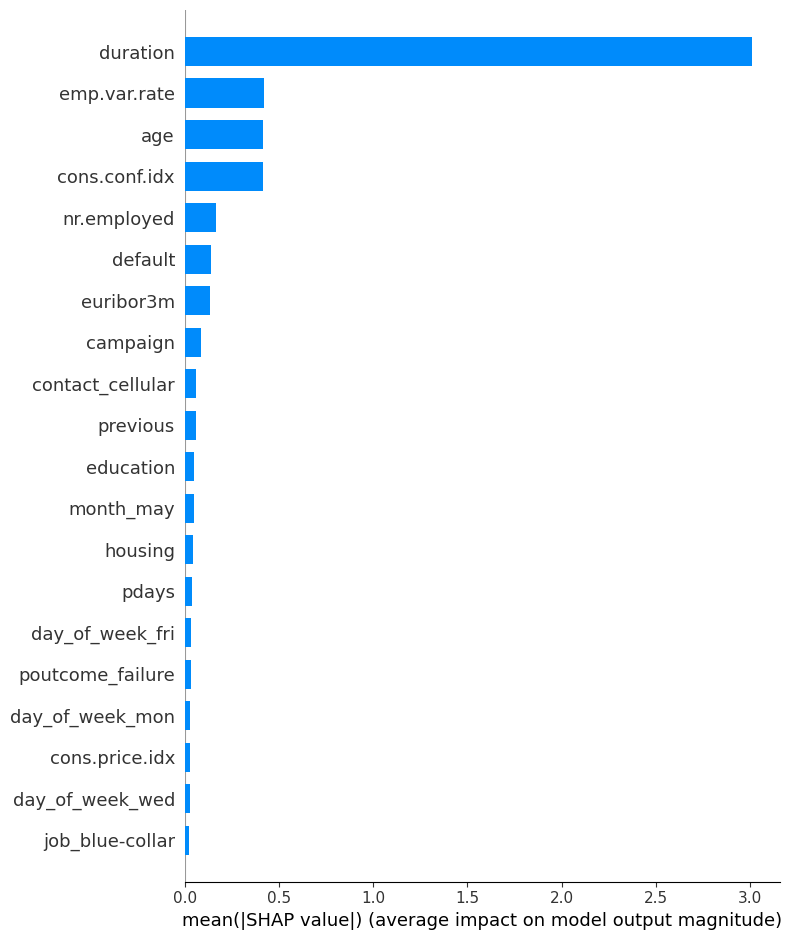

In [39]:
X = xgb_hyperport_results['Model']['data_processing'].transform(df.iloc[:, :-1])
X = xgb_hyperport_results['Model']['feature_engineering'].transform(X)

shap_values = shap.TreeExplainer(model).shap_values(X) 
shap.summary_plot(shap_values, X, plot_type="bar")

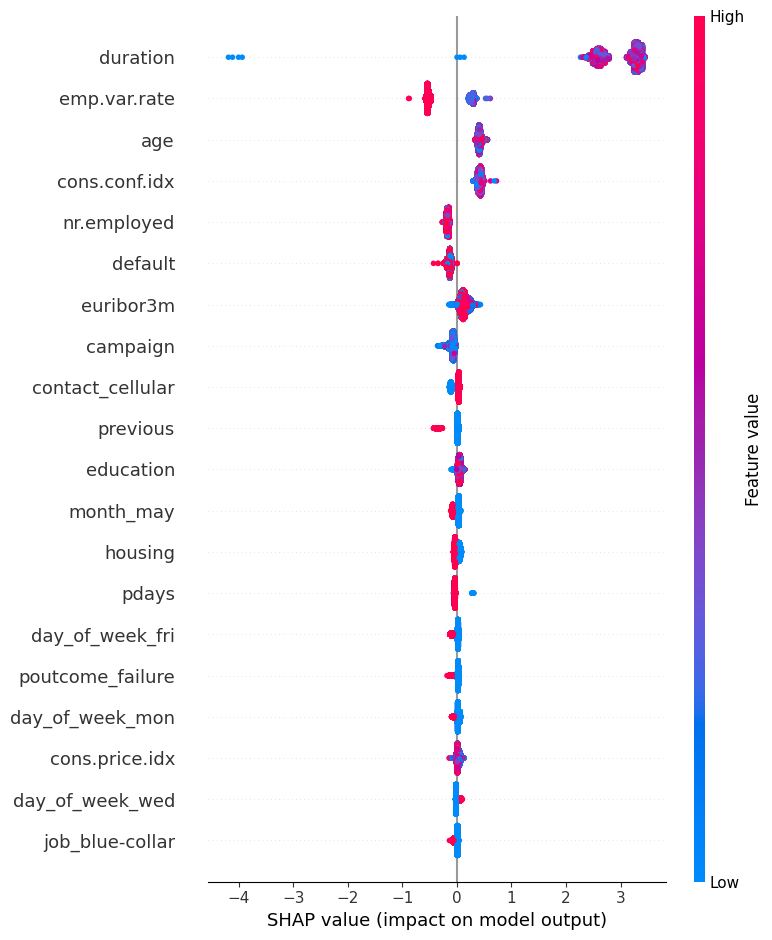

In [40]:
shap.summary_plot(shap_values, X)

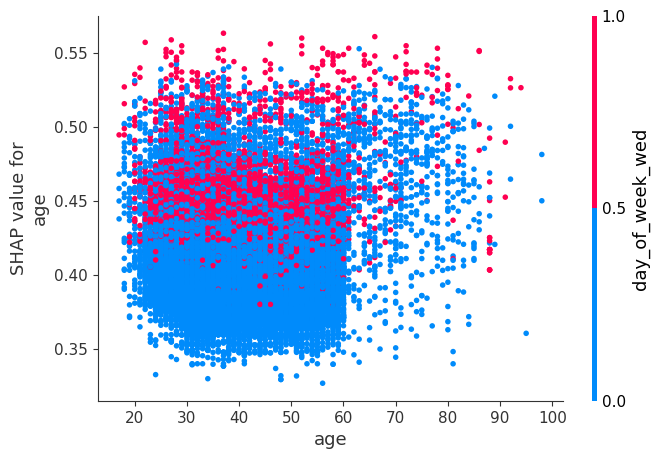

In [41]:
shap.dependence_plot('age', shap_values, X)

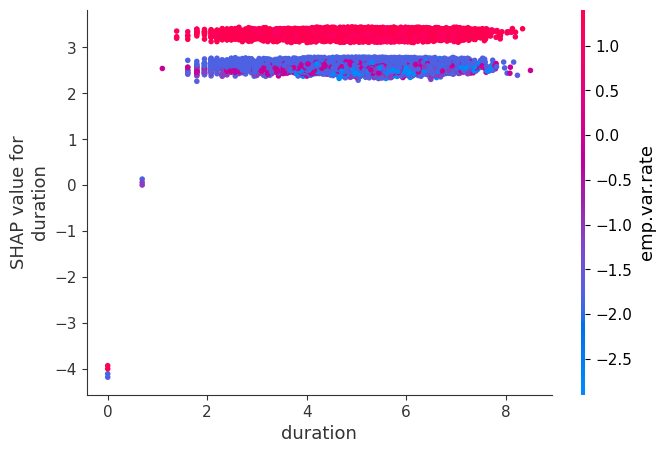

In [42]:
shap.dependence_plot('duration', shap_values, X)

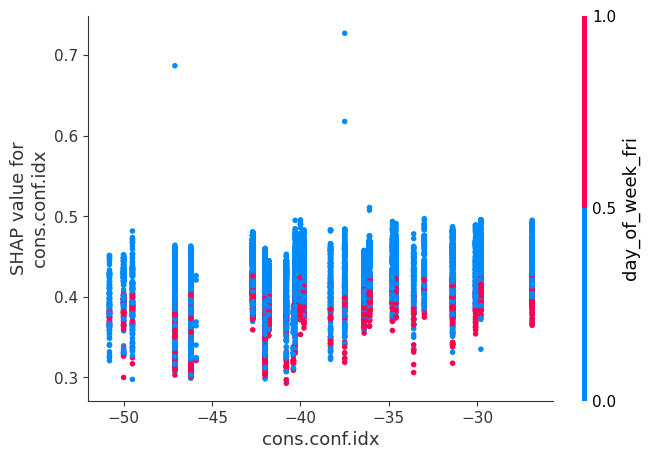

In [43]:
shap.dependence_plot('cons.conf.idx', shap_values, X)

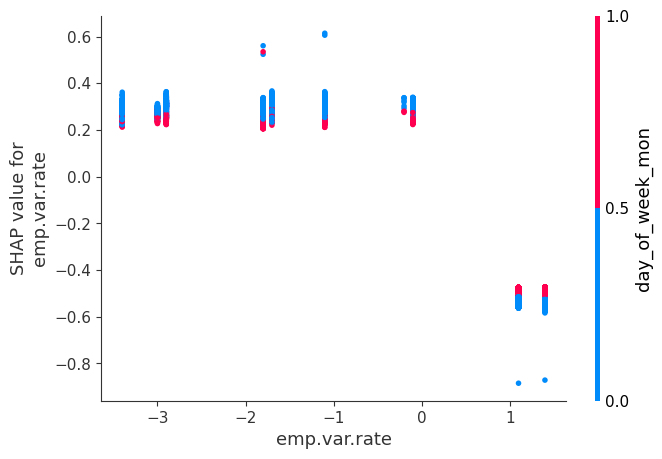

In [110]:
shap.dependence_plot('emp.var.rate', shap_values, X)

Найбільш впливовими змінними є `duration`, `cons.conf.idx`, `emp.var.rate`, `age`. 
Залежність між віком клієнта:

* не помічаю явної залежності між віком, можу сказати лише що клієнти віком від 60 років більше отримують кредитів
* cons.conf.idx, age сильно позитивно впливає на прийняття рішення, cons.conf.idx ж навпаки сильно негативно

### Аналіз залишків

In [75]:
y_predictions = xgb_hyperport_results['Model'].predict(df.iloc[:, :-1])
y_predictions_proba = xgb_hyperport_results['Model'].predict_proba(df.iloc[:, :-1])[:, 1]
y_true = np.where(df.iloc[:, -1] == "yes", 1, 0)

df['y_true'] = y_true
df['y_predictions_proba'] = y_predictions_proba
df['y_predictions'] = y_predictions

In [114]:
resid_df = df[df['y_true'] != df['y_predictions']]

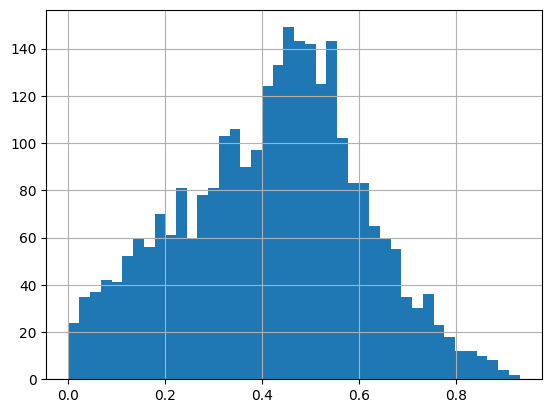

In [118]:
resid_df['y_predictions_proba'].hist(bins=42)
plt.show()

Розподіл зсунутий вправо, для покращення результатів моделі можемо додатково розглянути залишкові кейси та виділити групи, які у % помиляються більше, аніж передбачують. В подальшому це допоможе покращити, проте тестовий `roc_auc:` `95.5869%` є досить непоганим результатом.